In [5]:
pwd

'/home/xzhang/Projects/cellpose'

In [1]:
import os
import json
import shutil
import tempfile
import time
import glob
import tifffile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib


# import torch



In [2]:
import torch 
torch.device('cuda')

device(type='cuda')

In [9]:
pwd

'/data/programs/swincell_root/swincell/future_works/notebooks_plot_results'

# compare model performance of Swincell, with 3D-Unet and 3D Cellpose

In [17]:
# define path of segmentation results
from natsort import natsorted
import tifffile 
import glob
import numpy as np


fold =1 
downsample_factor = 1
min_size = 50*50/downsample_factor/downsample_factor
root_data_folder = '../../../Nanolive_dataset'
seg_result_files_swincell = natsorted(glob.glob(root_data_folder + f'/results_3d_v5_swincell_dsp{downsample_factor}_monai_minsize_{round(min_size)}/swincell*.tiff'))
seg_result_files_cellpose= natsorted(glob.glob(root_data_folder + f'/2d_cellpose_algo2/cellpose*.tif*'))
seg_result_files_unet = natsorted(glob.glob(root_data_folder + f'/results_3d_v5_unet_dsp{downsample_factor}_monai_minsize_{round(min_size)}/unet3d*.tiff'))

gt_files = natsorted(glob.glob(root_data_folder+'/labels/*tiff'))
# print(root_data_folder)
print(len(seg_result_files_swincell),len(gt_files),len(seg_result_files_unet),len(seg_result_files_cellpose))


10 10 10 10


In [8]:
# calculate mAP from segmented masks, take some time to run, save results to csv for future use
from swincell.utils.utils import matching
import pandas as pd
N_thresholds =5
mAP_3d_list_swincell=np.zeros((len(seg_result_files_swincell),N_thresholds))
mAP_3d_list_unet =np.zeros((len(seg_result_files_unet),N_thresholds))

output_swincell = pd.DataFrame()
output_unet = pd.DataFrame()

for i in range(len(seg_result_files_swincell)):
    for idxt,threshold in enumerate(np.linspace(0.5,1,N_thresholds)):
        gt_img = tifffile.imread(gt_files[i])
        if downsample_factor>1:
            gt_img = gt_img[0:-2:downsample_factor,0:-2:downsample_factor,0:-2:downsample_factor]
        # results 3d
        img_3d = tifffile.imread(seg_result_files_swincell[i])
        mAP_3d = matching(gt_img,img_3d,  thresh=threshold)
        
        df_temp = pd.DataFrame([mAP_3d])
        df_temp['img_id'] = str(gt_files[i].split('/')[-1])
        df_temp['method'] = 'swincell'
        output_swincell = pd.concat([output_swincell,df_temp])

for i in range(len(seg_result_files_unet)):
    for idxt,threshold in enumerate(np.linspace(0.5,1,N_thresholds)):
        gt_img = tifffile.imread(gt_files[i])
        if downsample_factor>1:
            gt_img = gt_img[0:-2:downsample_factor,0:-2:downsample_factor,0:-2:downsample_factor]
        # results 3d
        img_3d = tifffile.imread(seg_result_files_unet[i])
        mAP_3d = matching(gt_img,img_3d,  thresh=threshold)
        
        df_temp = pd.DataFrame([mAP_3d])
        df_temp['img_id'] = str(gt_files[i].split('/')[-1])
        df_temp['method'] = '3d unet'
        output_unet = pd.concat([output_unet,df_temp])

for i in range(len(seg_result_files_cellpose)):
    for idxt,threshold in enumerate(np.linspace(0.5,1,N_thresholds)):
        gt_img = tifffile.imread(gt_files[i])
        if downsample_factor>1:
            gt_img = gt_img[0:-2:downsample_factor,0:-2:downsample_factor,0:-2:downsample_factor]
        # results 3d
        img_3d = tifffile.imread(seg_result_files_unet[i])
        mAP_3d = matching(gt_img,img_3d,  thresh=threshold)
        
        df_temp = pd.DataFrame([mAP_3d])
        df_temp['img_id'] = str(gt_files[i].split('/')[-1])
        df_temp['method'] = '3d cellpose'
        output_cellpose = pd.concat([output_unet,df_temp])

print(output_unet.head(20))

#save output to csv, uncomment to save
# output_unet.to_csv('output_unet.csv')
# output_swincell.to_csv('output_swincell.csv')
# output_swincell.to_csv('output_swincell.csv')


  criterion  thresh  fp  tp  fn  precision    recall  accuracy        f1  \
0       iou   0.500  25  12   0   0.324324  1.000000  0.324324  0.489796   
0       iou   0.625  25  12   0   0.324324  1.000000  0.324324  0.489796   
0       iou   0.750  26  11   1   0.297297  0.916667  0.289474  0.448980   
0       iou   0.875  36   1  11   0.027027  0.083333  0.020833  0.040816   
0       iou   1.000  37   0  12   0.000000  0.000000  0.000000  0.000000   
0       iou   0.500  46  18   8   0.281250  0.692308  0.250000  0.400000   
0       iou   0.625  49  15  11   0.234375  0.576923  0.200000  0.333333   
0       iou   0.750  54  10  16   0.156250  0.384615  0.125000  0.222222   
0       iou   0.875  61   3  23   0.046875  0.115385  0.034483  0.066667   
0       iou   1.000  64   0  26   0.000000  0.000000  0.000000  0.000000   
0       iou   0.500  70  21   0   0.230769  1.000000  0.230769  0.375000   
0       iou   0.625  70  21   0   0.230769  1.000000  0.230769  0.375000   
0       iou 

In [23]:
#load previous output from csv
import pandas as pd
if 1: # load precomputed results?
    output_unet = pd.read_csv('../../../results/nanolive_output_unet.csv')  # 5 thesholds
    output_swincell = pd.read_csv('../../../results/nanolive_output_swincell.csv') # 5 thesholds
    output_compare_swincell_cellpose = pd.read_csv('../../../results/nanolive_output_compare_swincell_cellpose.csv') # 15 thesholds
    # seg_result_files_swincell = [1]*9  # number of files
    # seg_result_files_unet = [1]*9
    N_thresholds = 5

Nswin = 9
Nunet = 9
Ncp = 10

In [8]:
pwd

'/data/programs/swincell_root/swincell/future_works/notebooks_plot_results'

In [25]:
# output_3d_swincell= output_swincell[output_swincell['method']=='3d cellpose']
output_cellpose= output_compare_swincell_cellpose[output_compare_swincell_cellpose['method']=='cellpose']
# output_3d['precision'].values.shape

mAP_3d_list_swincell =output_swincell['precision'].values.reshape(Nswin,N_thresholds)
f1_3d_list_swincell =output_swincell['f1'].values.reshape(Nswin,N_thresholds)
fp_3d_list_swincell =output_swincell['fp'].values.reshape(Nswin,N_thresholds)
tp_3d_list_swincell =output_swincell['tp'].values.reshape(Nswin,N_thresholds)
fn_3d_list_swincell =output_swincell['fn'].values.reshape(Nswin,N_thresholds)

recall_3d_list_swincell =output_swincell['recall'].values.reshape(Nswin,N_thresholds)
accuracy_3d_list_swincell =output_swincell['accuracy'].values.reshape(Nswin,N_thresholds)


mAP_3d_list_unet =output_unet['precision'].values.reshape(Nunet,N_thresholds)
f1_3d_list_unet =output_unet['f1'].values.reshape(Nunet,N_thresholds)
fp_3d_list_unet =output_unet['fp'].values.reshape(Nunet,N_thresholds)
tp_3d_list_unet =output_unet['tp'].values.reshape(Nunet,N_thresholds)
fn_3d_list_unet =output_unet['fn'].values.reshape(Nunet,N_thresholds)

recall_3d_list_unet =output_unet['recall'].values.reshape(Nunet,N_thresholds)
accuracy_3d_list_unet =output_unet['accuracy'].values.reshape(Nunet,N_thresholds)


mAP_3d_list_cellpose =output_cellpose['precision'].values.reshape(Ncp,3*N_thresholds)
f1_3d_list_cellpose =output_cellpose['f1'].values.reshape(Ncp,3*N_thresholds)
fp_3d_list_cellpose =output_cellpose['fp'].values.reshape(Ncp,3*N_thresholds)
tp_3d_list_cellpose =output_cellpose['tp'].values.reshape(Ncp,3*N_thresholds)
fn_3d_list_cellpose =output_cellpose['fn'].values.reshape(Ncp,3*N_thresholds)

recall_3d_list_cellpose =output_cellpose['recall'].values.reshape(Ncp,3*N_thresholds)
accuracy_3d_list_cellpose =output_cellpose['accuracy'].values.reshape(Ncp,3*N_thresholds)
# from matplotlib import pyplot as plt
# fig,ax = plt.subplots(1,2,figsize=(12,4), dpi=300)
# idx =1
# ax[0].plot(np.linspace(0.5,1,N_thresholds),mAP_3d_list[idx],linewidth=2,label='3D cellpose') 
# ax[0].legend(loc='lower left',frameon=False,fontsize=12)
# # ax[0].legend()
# # change font size in the figure
# ax[0].set_xlabel('IoU Threshold',fontsize=12)
# ax[0].set_ylabel('mAP',fontsize=12)


In [18]:
print(f1_3d_list_unet)

[[1.         1.         1.         1.         0.        ]
 [0.66666667 0.51851852 0.2962963  0.11111111 0.        ]
 [0.91304348 0.91304348 0.91304348 0.47826087 0.        ]
 [0.96969697 0.96969697 0.90909091 0.36363636 0.        ]
 [0.77419355 0.77419355 0.77419355 0.64516129 0.        ]
 [1.         1.         1.         0.88888889 0.        ]
 [0.71111111 0.66666667 0.44444444 0.04444444 0.        ]
 [0.14583333 0.08333333 0.03125    0.         0.        ]
 [0.94736842 0.94736842 0.73684211 0.15789474 0.        ]
 [0.72340426 0.5106383  0.12765957 0.         0.        ]]


Text(0.5, 0, 'IoU threshold')

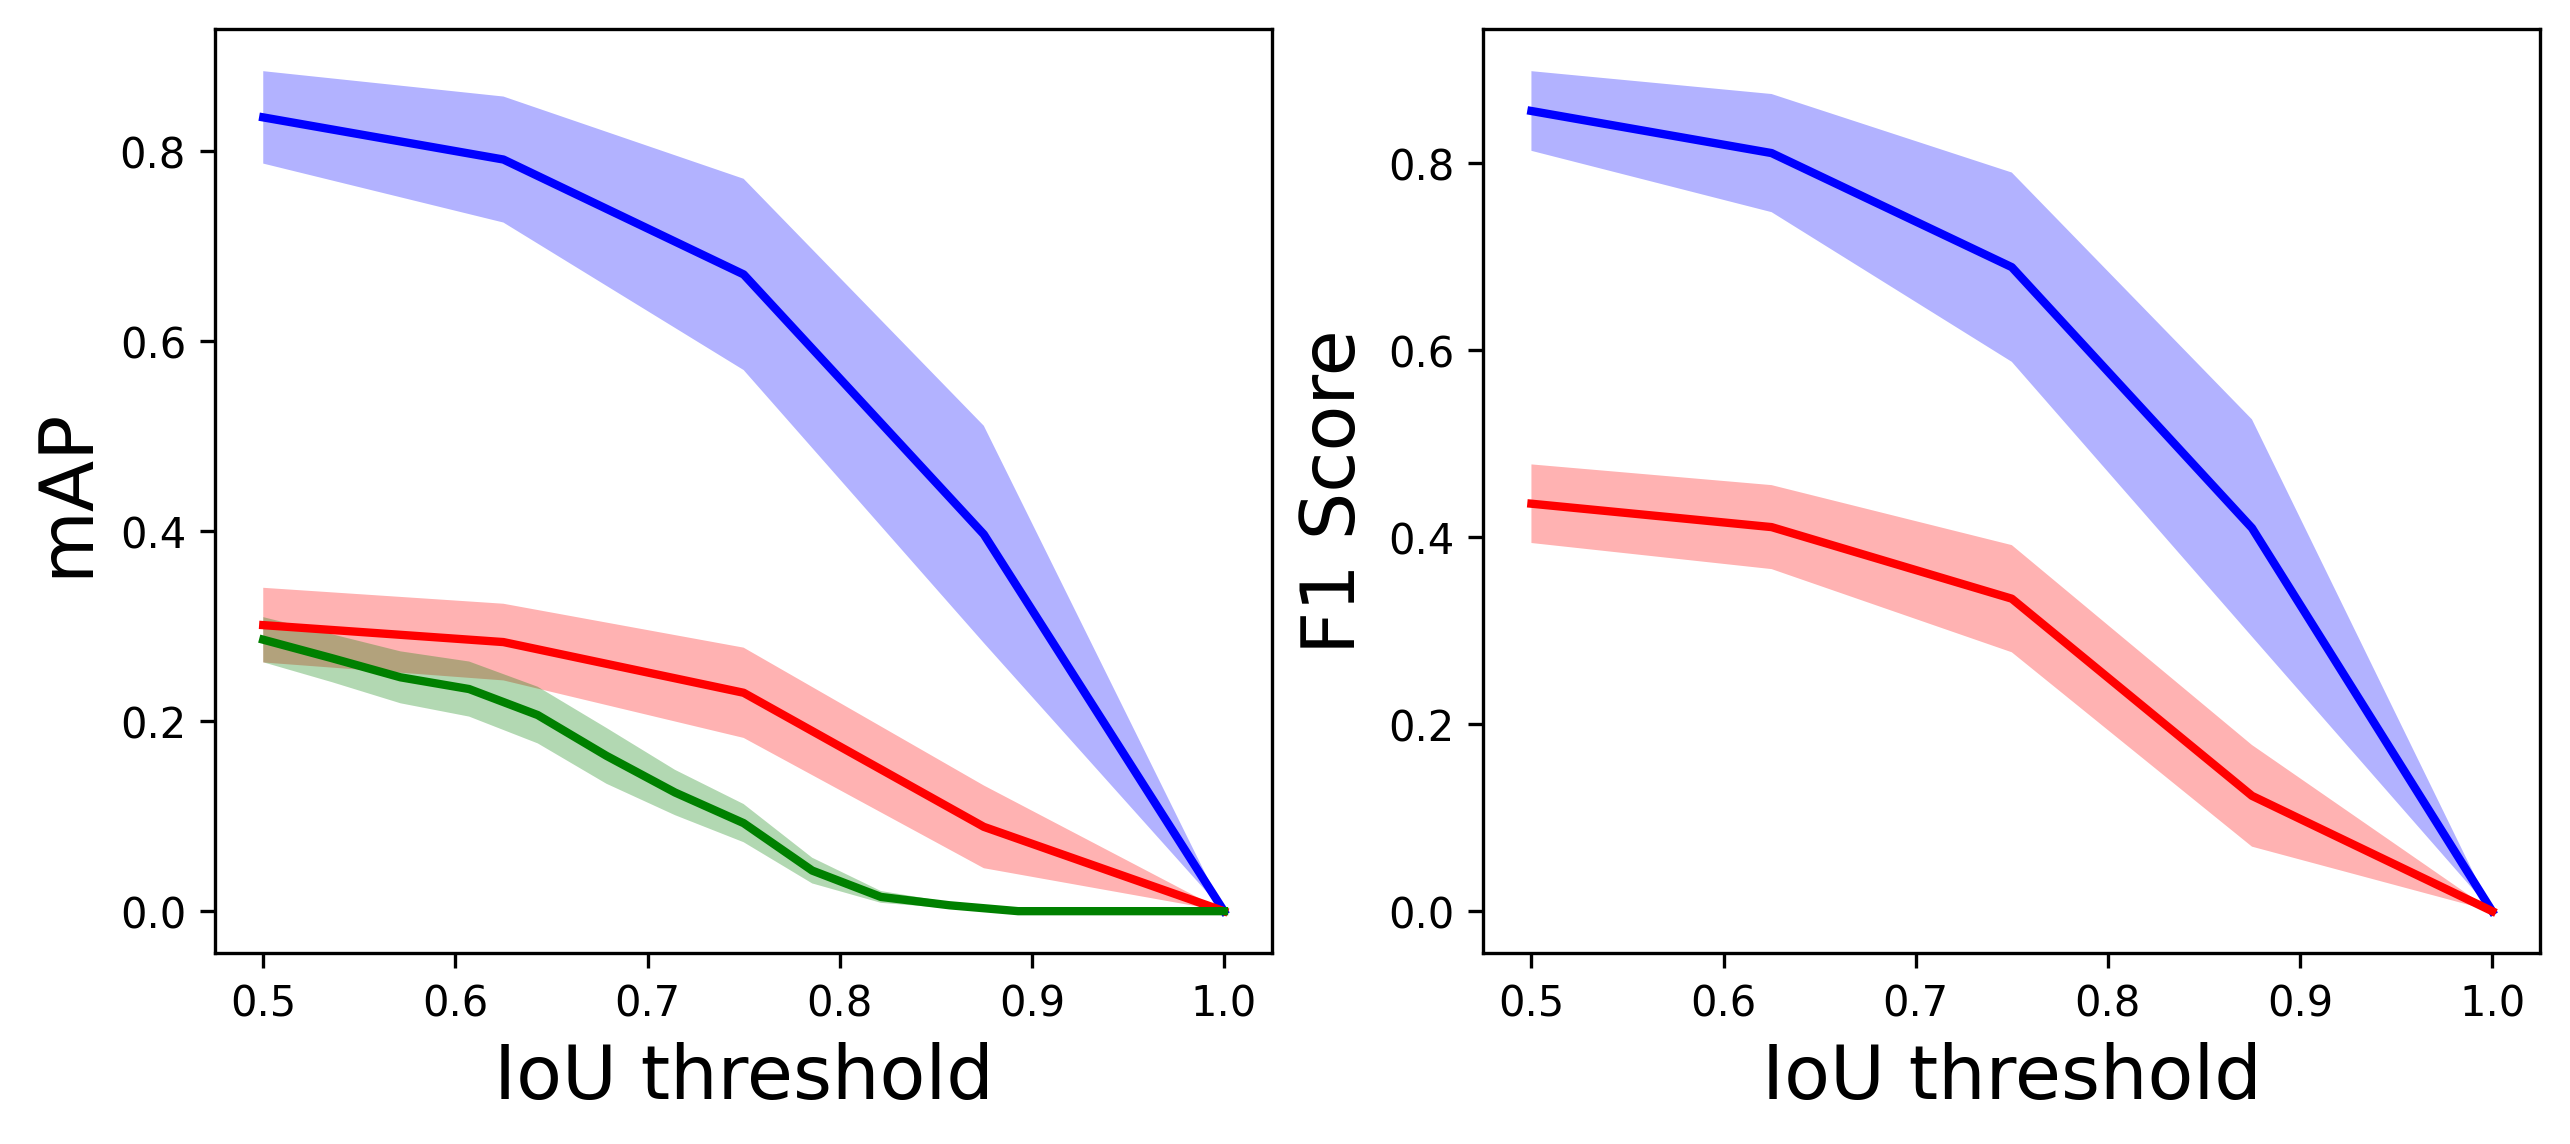

In [30]:
import numpy as np
from matplotlib import pyplot as plt
from swincell.utils.utils import plot_with_se

N_thresholds =5
iou_thresholds = np.linspace(0.5,1,N_thresholds)
iou_thresholds2 = np.linspace(0.5,1,3*N_thresholds)
fig,ax = plt.subplots(1,2,figsize=(10,4), dpi=300)
plot_with_se(ax[0],mAP_3d_list_swincell,iou_thresholds,label='swincell',color='blue')
plot_with_se(ax[0],mAP_3d_list_unet,iou_thresholds,label='3D unet + flow',color='red')
plot_with_se(ax[0],mAP_3d_list_cellpose,iou_thresholds2,label='3D cellpose',color='green')
ax[0].set_ylabel('mAP',fontsize =18)
ax[0].set_xlabel('IoU threshold',fontsize =18)
  

plot_with_se(ax[1],f1_3d_list_swincell,iou_thresholds,label='swinunetr',color='blue')
plot_with_se(ax[1],f1_3d_list_unet,iou_thresholds,label='unet',color='red')
ax[1].set_ylabel('F1 Score',fontsize =18)
ax[1].set_xlabel('IoU threshold',fontsize =18)

Text(0, 0.5, 'False Positive')

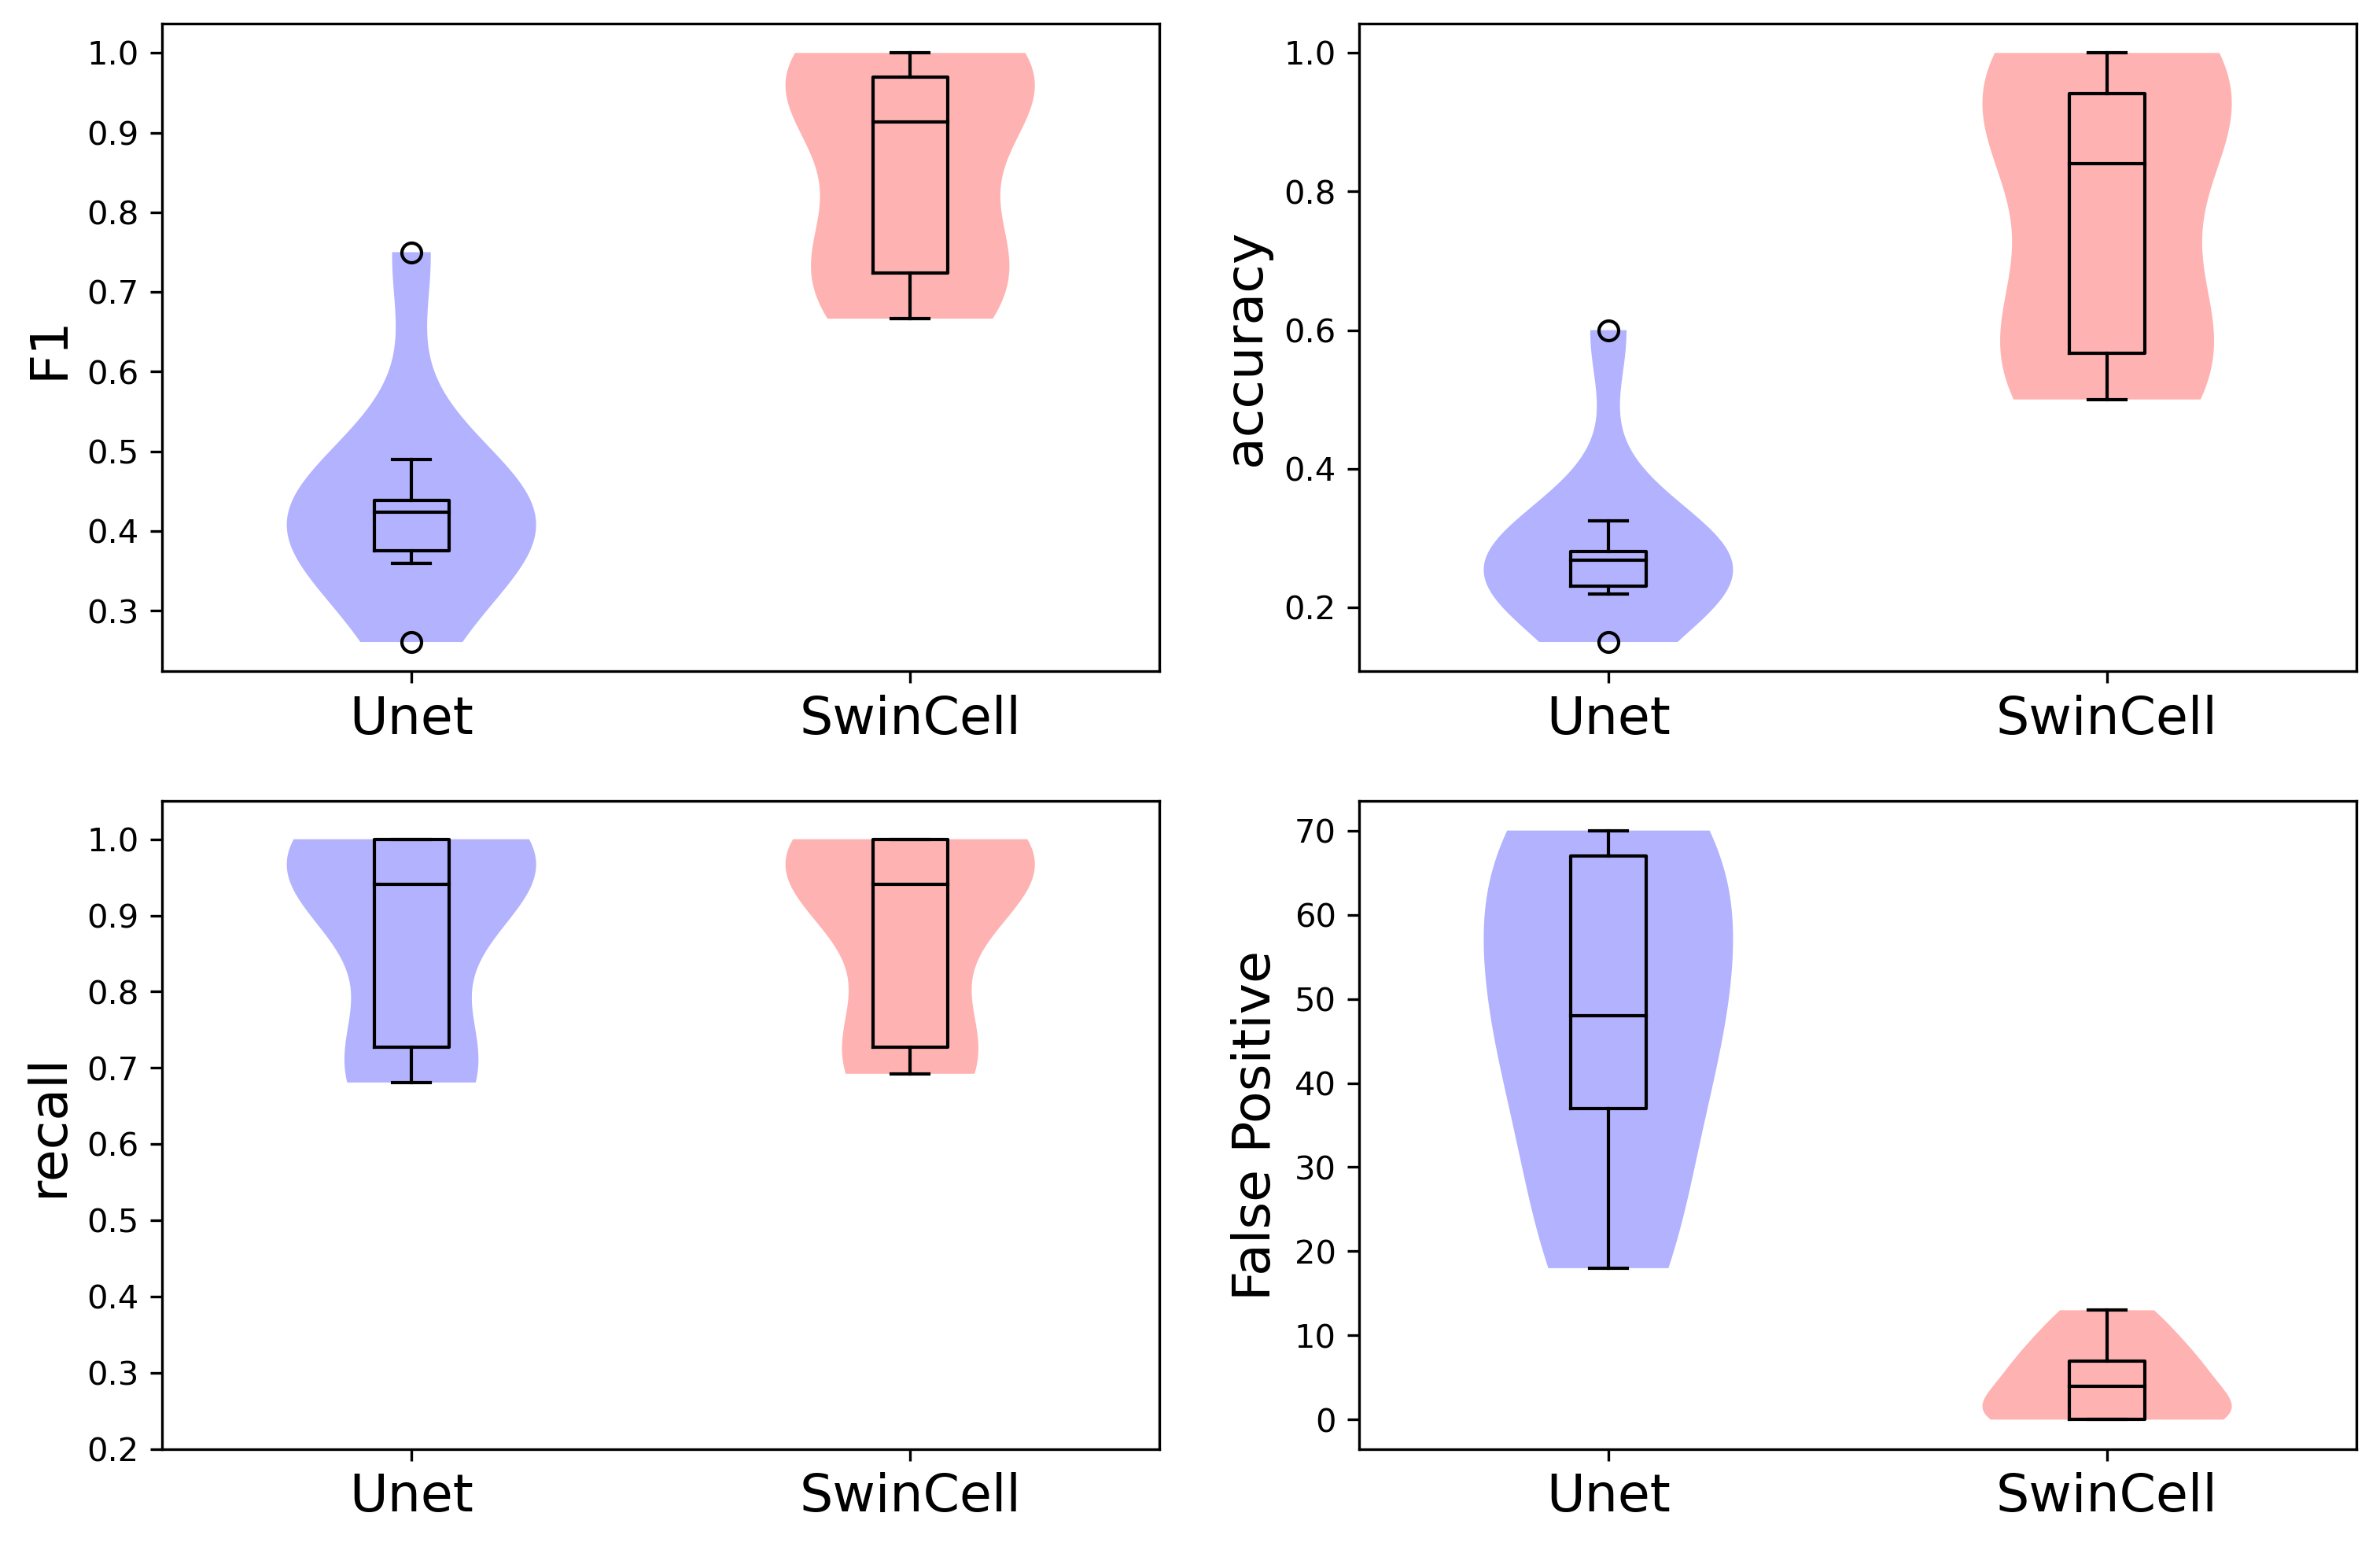

In [19]:

from utils.utils import plot_box_with_violin
threshold_idx = 0 #  0 for 0.5, 1 for 0.6, 2 for 0.7, 3 for 0.8
f1_3d_list_05= [f1_3d_list_unet[:,threshold_idx],f1_3d_list_swincell[:,threshold_idx]]  #first column is threshold=0.5
# fp_3d_list_05= [fp_3d_list_unet[:,0],fp_3d_list_swinunetr[:,0]] 
fp_3d_list_05= [fp_3d_list_unet[:,threshold_idx],fp_3d_list_swincell[:,threshold_idx]]
tp_3d_list_05= [tp_3d_list_unet[:,threshold_idx],tp_3d_list_swincell[:,threshold_idx]]
fn_3d_list_05= [fn_3d_list_unet[:,threshold_idx],fn_3d_list_swincell[:,threshold_idx]]

recall_3d_list_05= [recall_3d_list_unet[:,threshold_idx],recall_3d_list_swincell[:,threshold_idx]]
accuracy_3d_list_05= [accuracy_3d_list_unet[:,threshold_idx],accuracy_3d_list_swincell[:,threshold_idx]]


fig,ax = plt.subplots(2,2,figsize=(12,8), dpi=300)
ax[0][0] = plot_box_with_violin(ax[0][0],f1_3d_list_05,facecolorlist=['blue','red'])
ax[0][0].set_xticklabels(['Unet', 'SwinCell'],fontsize =16)
ax[0][0].set_ylabel('F1',fontsize =16)

# ax[0][1] = plot_box_with_violin(ax[0][1],fp_3d_list_05,facecolor='red')
# ax[0][1].set_xticklabels(['Unet', 'SwinUnetr'],fontsize =16)
# ax[0][1].set_ylabel('fp',fontsize =16)
ax[0][1] = plot_box_with_violin(ax[0][1],accuracy_3d_list_05,facecolorlist=['blue','red'])
ax[0][1].set_xticklabels(['Unet', 'SwinCell'],fontsize =16)
ax[0][1].set_ylabel('accuracy',fontsize =16)

ax[1][0] = plot_box_with_violin(ax[1][0],recall_3d_list_05,facecolorlist=['blue','red'])
ax[1][0].set_xticklabels(['Unet', 'SwinCell'],fontsize =16)
ax[1][0].set_ylabel('recall',fontsize =16)
ax[1][0].set_ylim([0.2,1.05])

ax[1][1] = plot_box_with_violin(ax[1][1],fp_3d_list_05,facecolorlist=['blue','red'])
ax[1][1].set_xticklabels(['Unet', 'SwinCell'],fontsize =16)
ax[1][1].set_ylabel('False Positive',fontsize =16)

10 20 10
18 0
(96, 512, 512) (96, 512, 512) (96, 512, 512)
15 0


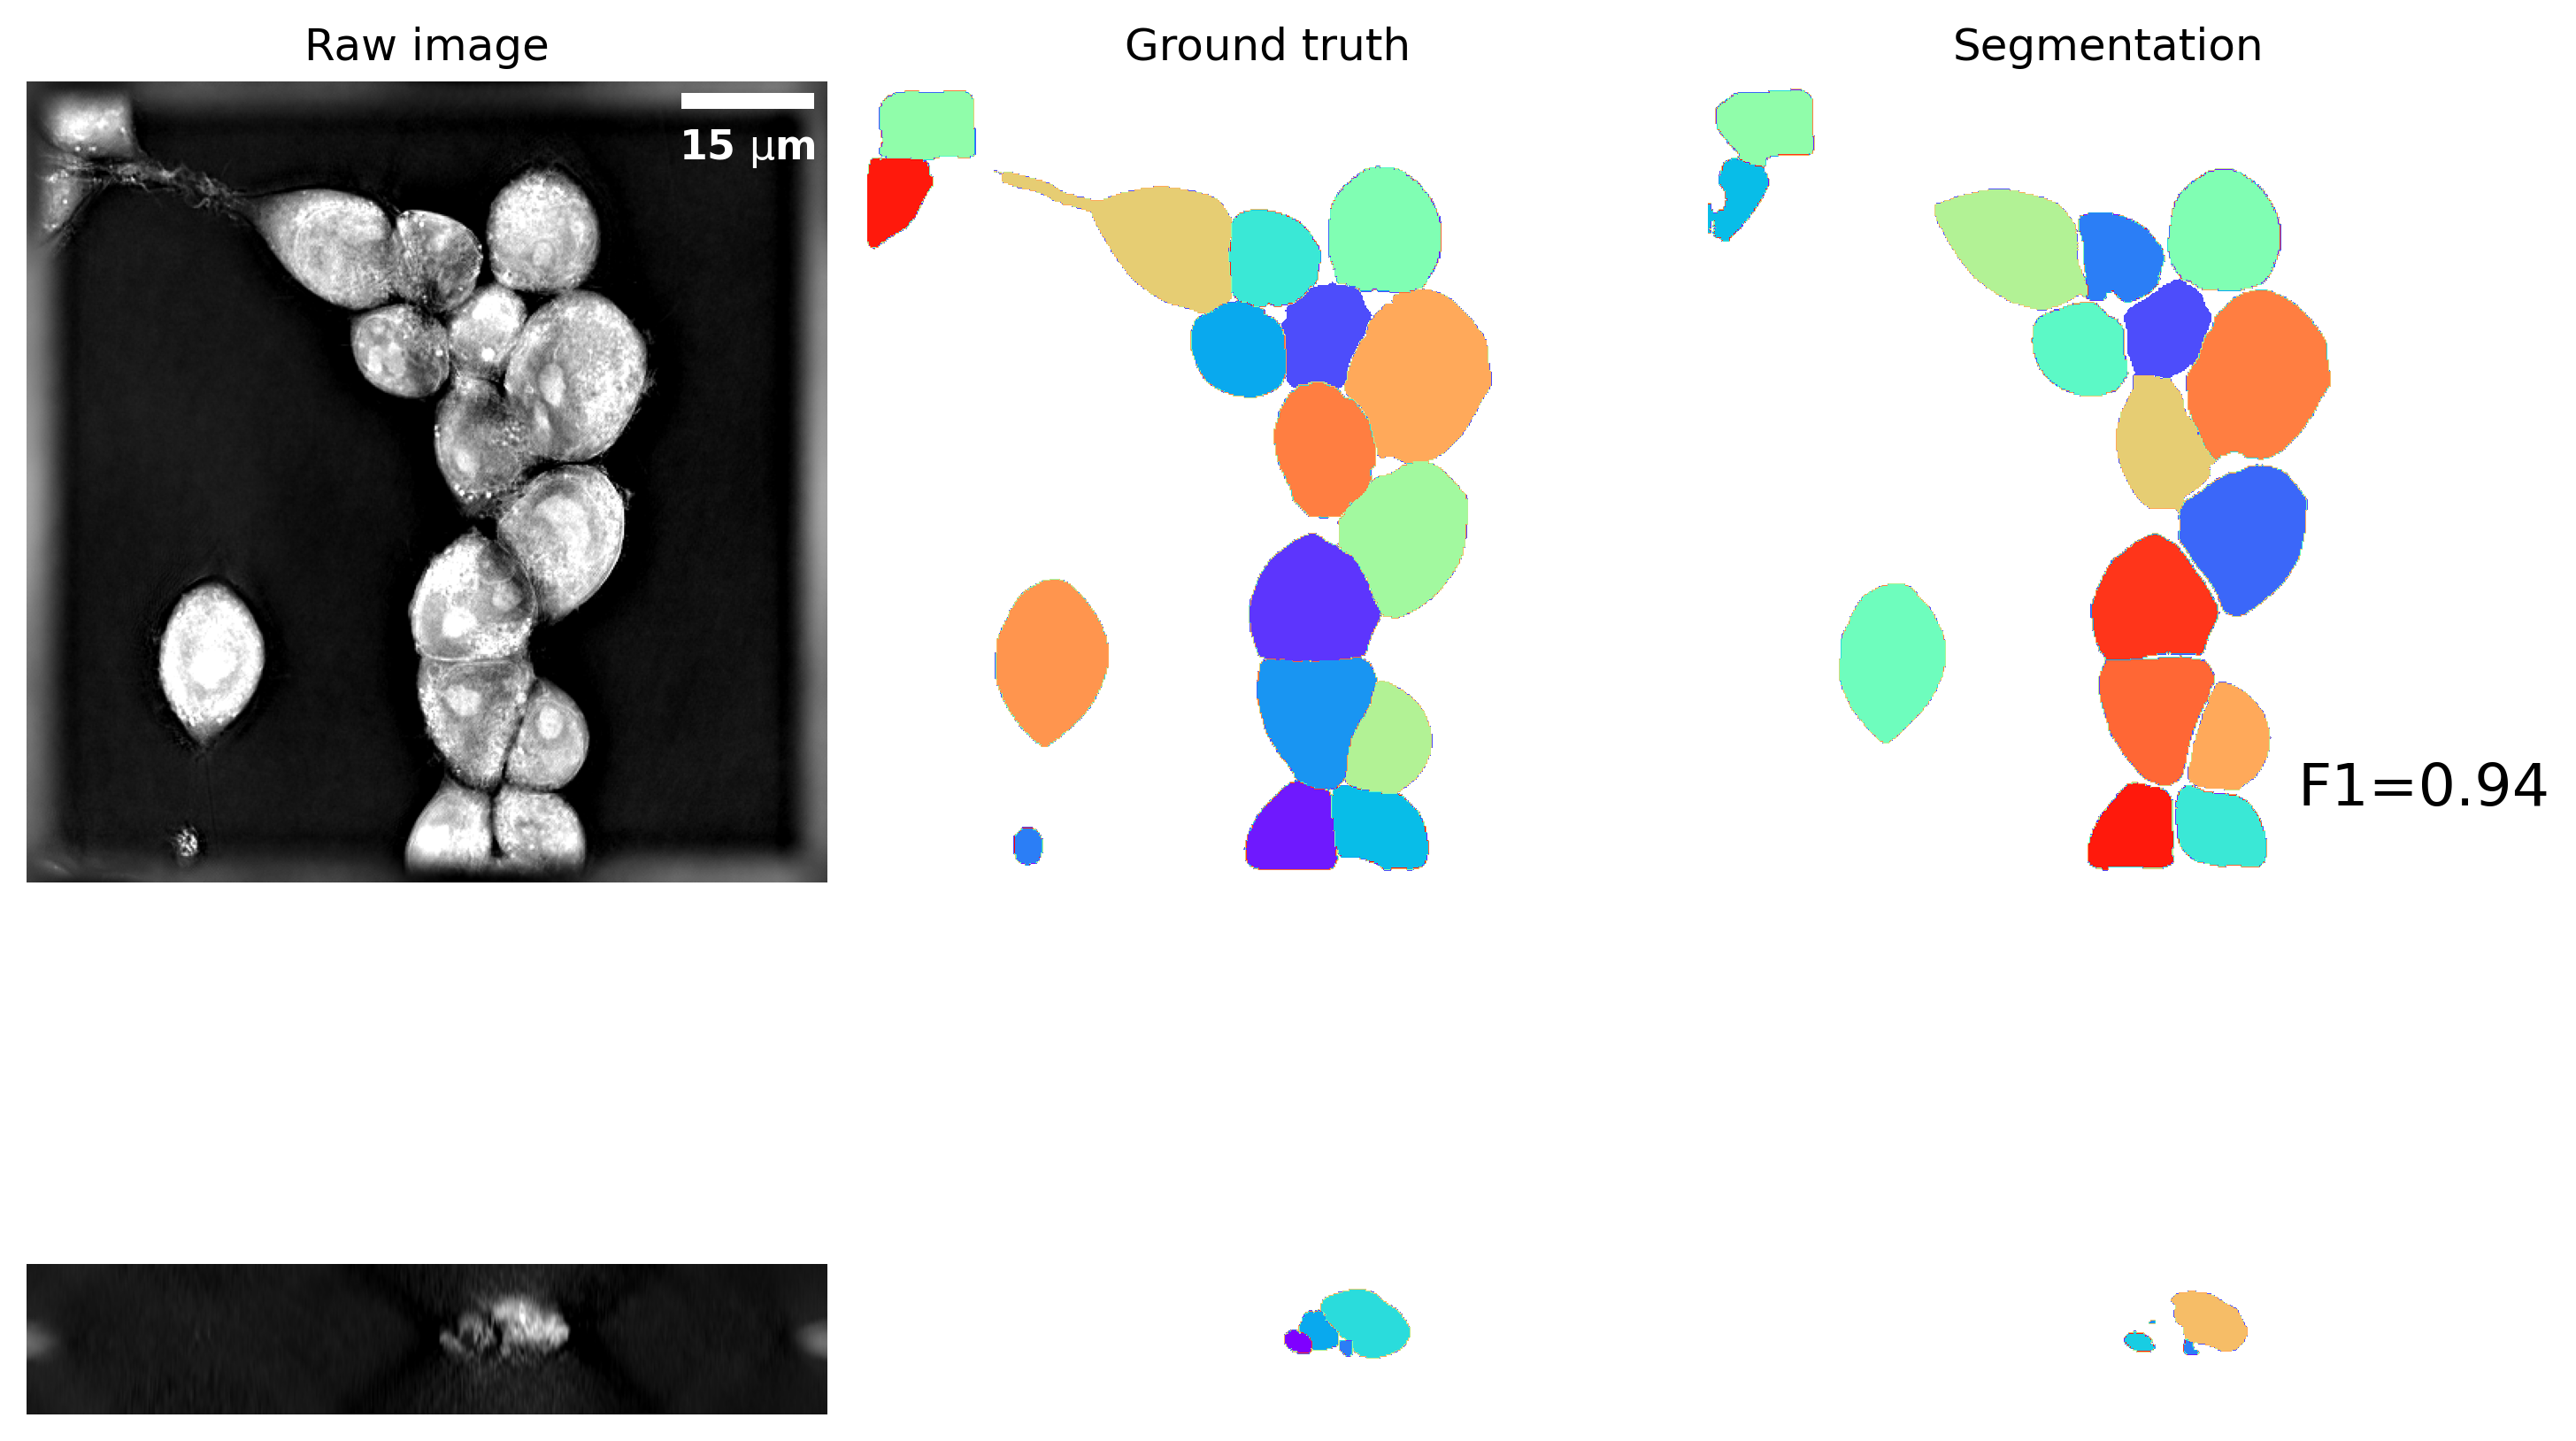

In [23]:
# show swinunetr result only 
from cv2_utils import get_random_cmap
from natsort import natsorted
import numpy as np
import glob
import tifffile
from matplotlib import pyplot as plt
from stardist_matching import matching
import scipy.ndimage as ndimage

from matplotlib_scalebar.scalebar import ScaleBar
# update configuration, not needed if run code from beginning
fontsize= 16
model_type = 'swinunetr'
downsample_factor = 1
min_size = 50*50//downsample_factor//downsample_factor



root_folder = '/home/xzhang/Projects/cellpose/Nanolive_mem_cellpose_data_v5_nor_1_99'
image_files = natsorted(glob.glob(root_folder + '/images/*.tiff'))
gt_files = natsorted(glob.glob(root_folder + '/labels/*.tiff'))
seg_files = natsorted(glob.glob(root_folder + f'/results_3d_v5_{model_type}_dsp{downsample_factor}_monai_minsize_{round(min_size)}/*.tiff'))

print(len(image_files), len(seg_files), len(gt_files))

from skimage import measure
# mask =  measure.label(mask)

file_idx = 3
img_raw = tifffile.imread(image_files[file_idx])
img_gt = tifffile.imread(gt_files[file_idx])
img_gt = measure.label(img_gt,background=0)

if downsample_factor>1:
      img_gt = img_gt[:-2:downsample_factor,:-2:downsample_factor,:-2:downsample_factor]
      # img_seg = img_seg[:-2:downsample_factor,:-2:downsample_factor,:-2:downsample_factor]

print(img_gt.max(),img_gt.min())

textx = img_raw.shape[2]-135
texty = img_raw.shape[1]-50


img_seg = tifffile.imread(seg_files[file_idx])
print(img_raw.shape,img_seg.shape,img_gt.shape)
slice1 = 50//downsample_factor
slice2 = 450//downsample_factor
fig,ax = plt.subplots(2,3,figsize=(10,8), dpi=300)
cell_num =30

nanolivef1 =matching(img_gt, img_seg, thresh=0.5).f1

ax[0,0].imshow(img_raw[slice1],cmap='gray')
ax[0,0].set_title('Raw image')
scalebar = ScaleBar(90/512, "um", length_fraction=0.2,height_fraction=0.02,box_alpha=0.0,color='white',location='',font_properties={'size': 11,'weight':'bold'})            
ax[0,0].add_artist(scalebar)

ax[0,1].imshow(img_gt[slice1],cmap= get_random_cmap(cell_num))
ax[0,1].set_title('Ground truth')

ax[0,2].imshow(img_seg[slice1],cmap= get_random_cmap(cell_num))
ax[0,2].set_title('Segmentation')
ax[0,2].text(textx, texty, 'F1={:0.2f}'.format(nanolivef1), bbox=dict(facecolor='white', alpha=0.8,edgecolor='white'), fontsize=fontsize)




# side_raw = ndimage.zoom(img_raw[:,slice2],(2,1),mode='nearest')
# side_gt = ndimage.zoom(img_gt[:,slice2],(2,1),mode='wrap',order=1)
# side_seg  = ndimage.zoom(img_seg[:,slice2],(2,1),mode='nearest')

side_raw = img_raw[:,slice2]
side_gt = img_gt[:,slice2]
side_seg  = img_seg[:,slice2]
print(side_gt.max(),side_gt.min())
ax[1,0].imshow(side_raw,cmap='gray')
ax[1,1].imshow(side_gt,cmap= get_random_cmap(cell_num))
ax[1,2].imshow(side_seg,cmap= get_random_cmap(cell_num))

for i in range(3):
      for j in range(2):
            ax[j,i].axis('off')
plt.tight_layout()


35 0
22 0


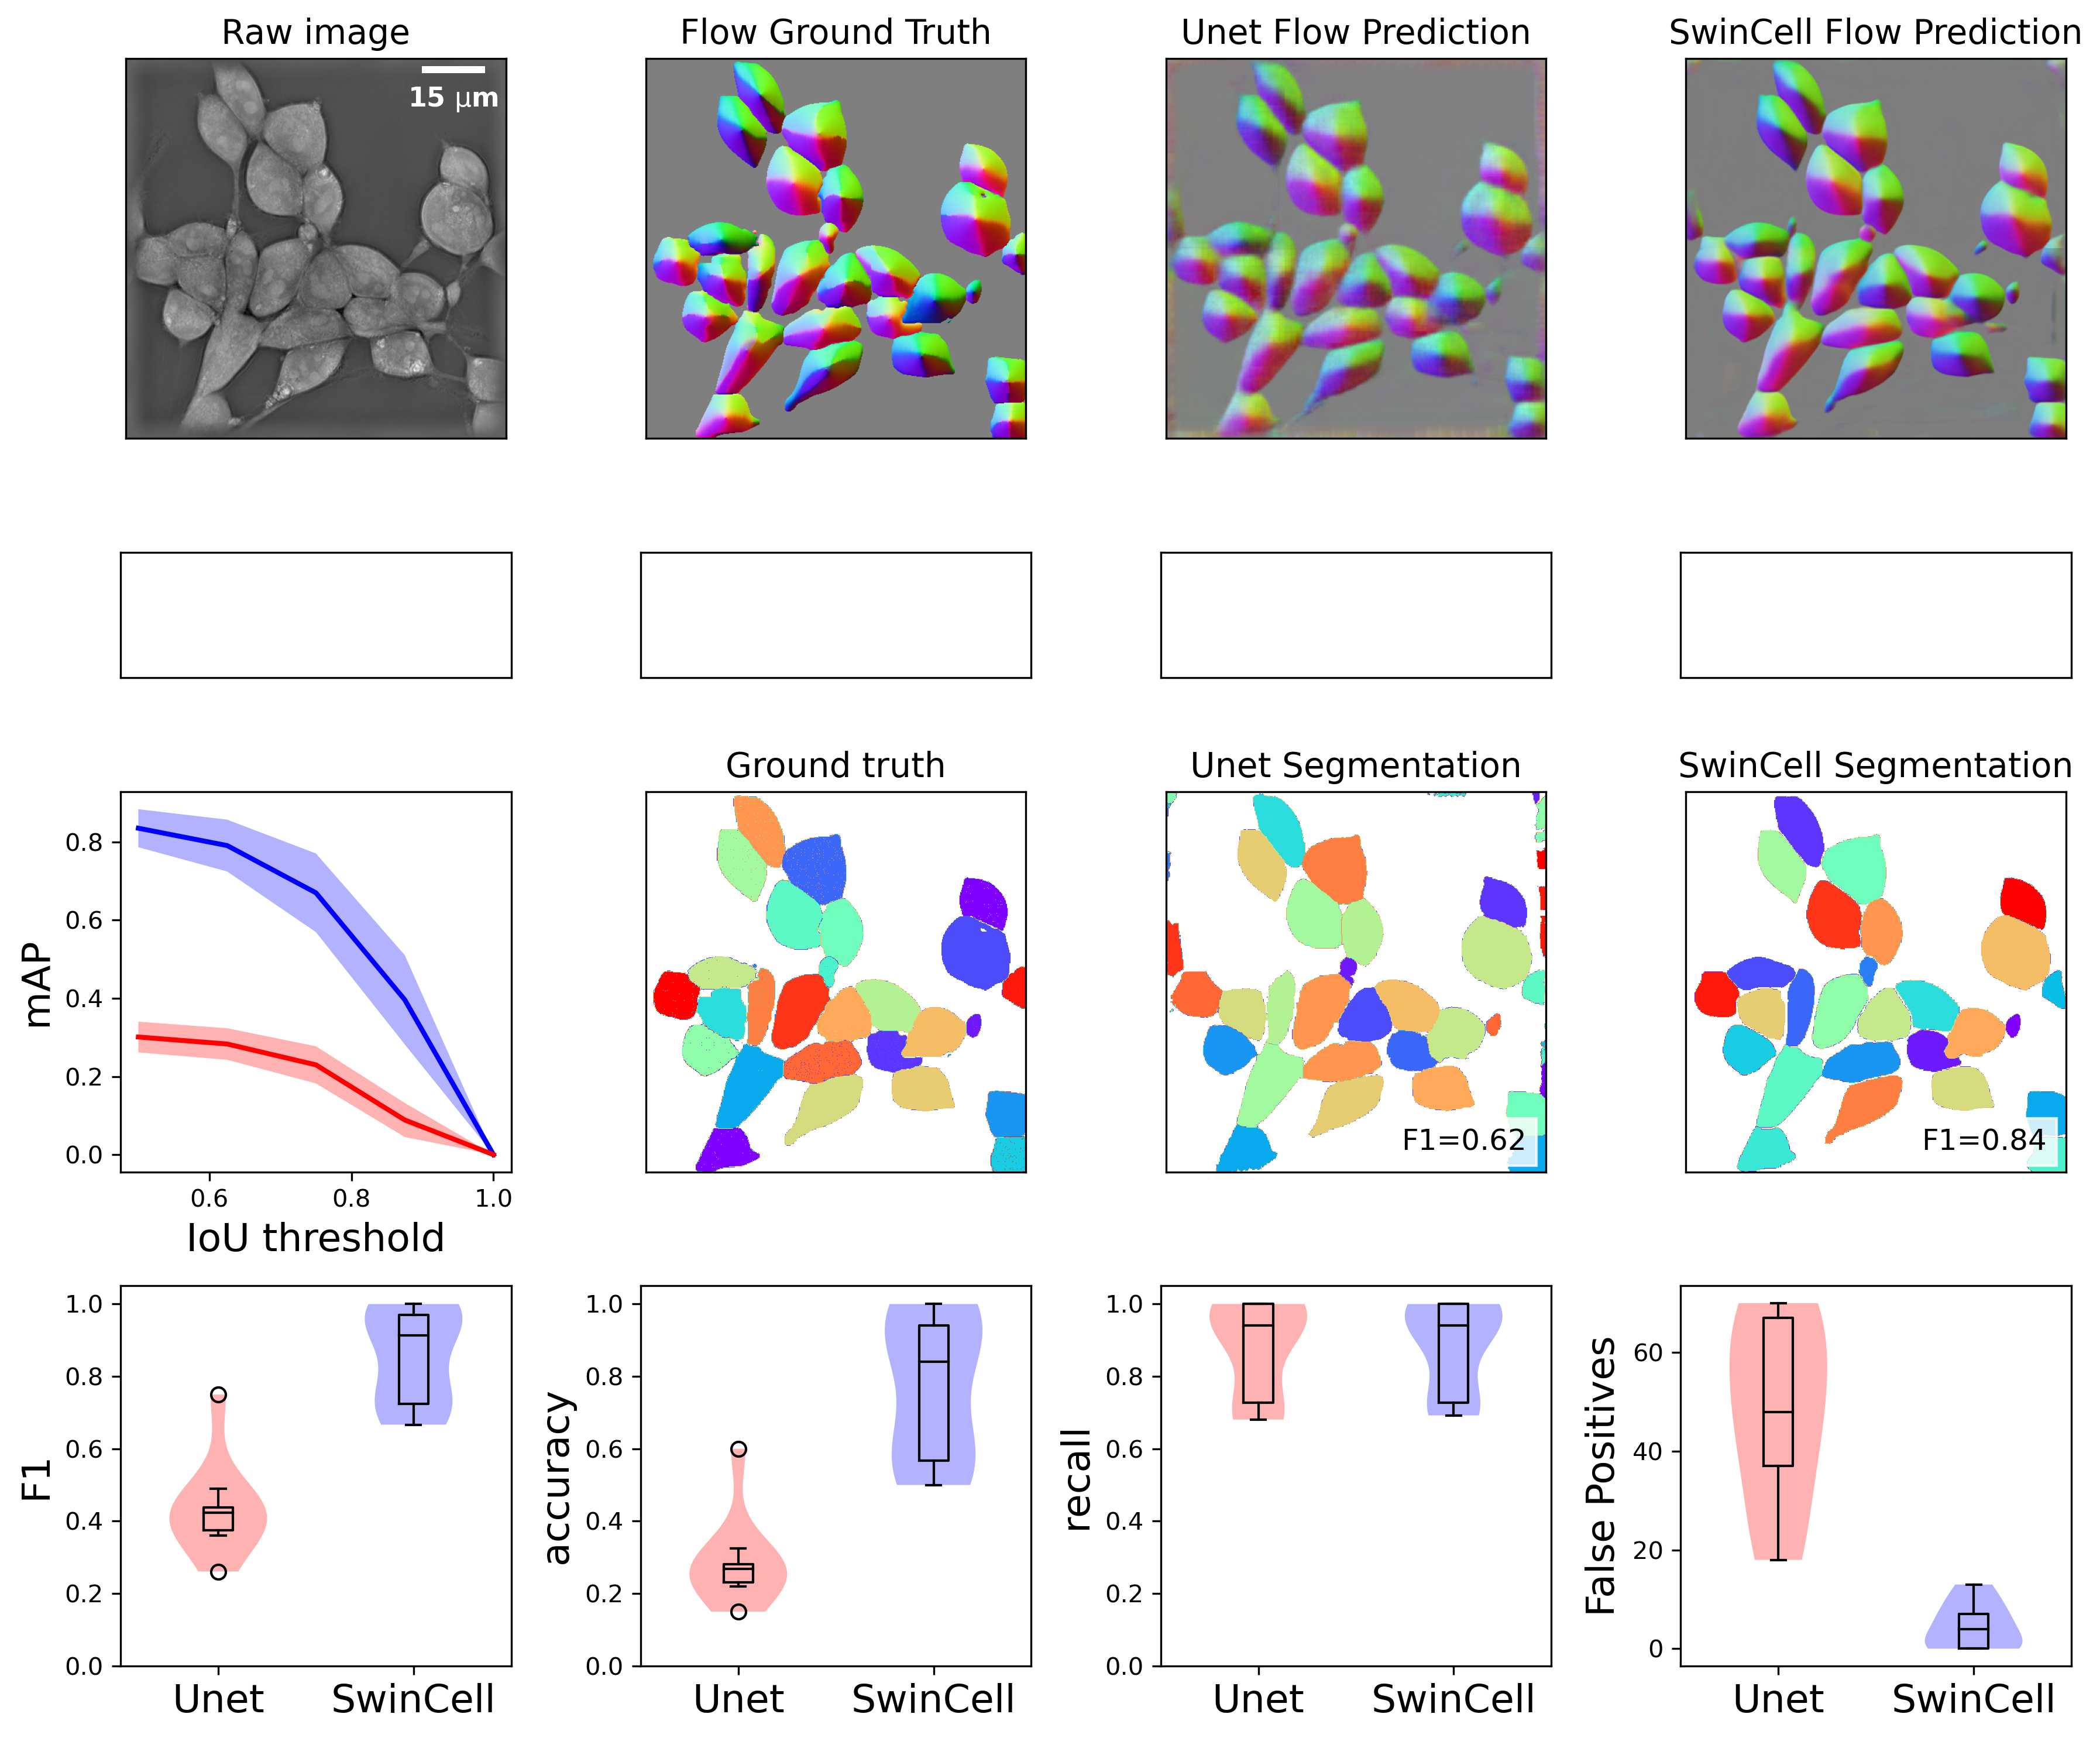

In [35]:
# compare unet and swinunetr
from cv2_utils import get_random_cmap
from natsort import natsorted
import numpy as np
import glob
import tifffile
from matplotlib import pyplot as plt
from stardist_matching import matching
from skimage import measure
# import scipy.ndimage as ndimage
# import matplotlib.gridspec as gridspec
from matplotlib_scalebar.scalebar import ScaleBar
from utils.utils import plot_with_se, plot_box_with_violin
# update configuration, not needed if run code from beginning
title_fontsize = 14
matching_threshold = 0.8
downsample_factor = 1
min_size = 50*50//downsample_factor//downsample_factor

N_thresholds =5

root_folder = '/home/xzhang/Projects/cellpose/Nanolive_mem_cellpose_data_v5_nor_1_99'
# image_files = natsorted(glob.glob(root_folder + '/images/*.tiff'))# 
# import re
image_files = natsorted(glob.glob('/data/nanolive/06222023_segmentation/*.tiff'))# use raw image instead of normalized image
# print(image_files[:3])
image_files = [f for f in image_files if "/2%" in f or "/3_" in f or "/12_" in f or "/15_" in f or "/16_" in f or "/17_" in f or "/31_" in f or "/50u" in f \
               or "/53_" in f or "/73" in f]

#-------------------------------------------
gt_files = natsorted(glob.glob(root_folder + '/labels/*.tiff'))
seg_files_swinunetr = natsorted(glob.glob(root_folder + f'/results_3d_v5_swinunetr_dsp{downsample_factor}_monai_minsize_{round(min_size)}/cellpose*.tiff'))
seg_files_unet = natsorted(glob.glob(root_folder + f'/results_3d_v5_unet_dsp{downsample_factor}_monai_minsize_{round(min_size)}/cellpose*.tiff'))

gt_flow = natsorted(glob.glob(root_folder + '/masks_with_flows/*.tiff'))
flow_files_swinunetr = natsorted(glob.glob(root_folder + f'/results_3d_v5_swinunetr_dsp{downsample_factor}_monai_minsize_{round(min_size)}/logits*.tiff'))
flow_files_unet = natsorted(glob.glob(root_folder + f'/results_3d_v5_unet_dsp{downsample_factor}_monai_minsize_{round(min_size)}/logits*.tiff'))

# print(len(image_files), len(seg_files_unet), len(seg_files_swinunetr), len(gt_files), len(flow_files_unet), len(flow_files_swinunetr))



# choose file and slices to show   
file_idx = 5
slice1 = 40//downsample_factor # size in z, default 40
slice2 = 450//downsample_factor

img_raw = tifffile.imread(image_files[file_idx])
img_gt = tifffile.imread(gt_files[file_idx])
img_gt = measure.label(img_gt,background=0)


if downsample_factor>1:
      img_gt = img_gt[:-2:downsample_factor,:-2:downsample_factor,:-2:downsample_factor]
      # img_seg = img_seg[:-2:downsample_factor,:-2:downsample_factor,:-2:downsample_factor]

print(img_gt.max(),img_gt.min())



img_seg_swinunetr = tifffile.imread(seg_files_swinunetr[file_idx])
img_seg_unet = tifffile.imread(seg_files_unet[file_idx])
flow_swinunetr = tifffile.imread(flow_files_swinunetr[file_idx])
flow_unet = tifffile.imread(flow_files_unet[file_idx])
flow_gt = tifffile.imread(gt_flow[file_idx])

# print(img_raw.shape,img_seg.shape,img_gt.shape,img_seg_swinunetr.shape,img_seg_unet.shape,'\n',flow_swinunetr.shape,flow_unet.shape)


#only  keep center region of the image ???
if 0:
      sfxy = 20 # shift in xy direction
      img_raw = img_raw[5:-5,sfxy:-sfxy,sfxy:-sfxy]
      img_gt = img_gt[5:-5,sfxy:-sfxy,sfxy:-sfxy]
      img_seg_swinunetr = img_seg_swinunetr[5:-5,sfxy:-sfxy,sfxy:-sfxy]
      img_seg_unet = img_seg_unet[5:-5,sfxy:-sfxy,sfxy:-sfxy]
      flow_swinunetr = flow_swinunetr[:,5:-5,sfxy:-sfxy,sfxy:-sfxy]
      flow_unet = flow_unet[:,5:-5,sfxy:-sfxy,sfxy:-sfxy]
      flow_gt = flow_gt[:,5:-5,sfxy:-sfxy,sfxy:-sfxy]
else:
      sfxy = 0
# text position
textx = img_raw.shape[2]-195-sfxy
texty = img_raw.shape[1]-30-sfxy
fig,ax = plt.subplots(4,4,figsize=(12,10), dpi=300,gridspec_kw={'height_ratios': [1, 0.33, 1,1]})
cell_num = 30

nanolivef1_swinunetr =matching(img_gt, img_seg_swinunetr, thresh=matching_threshold).f1
nanolivef1_unet =matching(img_gt, img_seg_unet, thresh=matching_threshold).f1

ax[0,0].imshow(img_raw[slice1],cmap='gray')
ax[0,0].set_title('Raw image',fontsize=title_fontsize)
scalebar = ScaleBar(90/512, "um", length_fraction=0.2,height_fraction=0.02,box_alpha=0.0,color='white',location='',font_properties={'size': 11,'weight':'bold'})            
ax[0,0].add_artist(scalebar)

ax[2,1].imshow(img_gt[slice1],cmap= get_random_cmap(cell_num))
ax[2,1].set_title('Ground truth',fontsize=title_fontsize)

ax[2,2].imshow(img_seg_unet[slice1],cmap= get_random_cmap(cell_num))
ax[2,2].set_title('Unet Segmentation',fontsize=title_fontsize)
ax[2,2].text(textx, texty, 'F1={:0.2f}'.format(nanolivef1_unet), bbox=dict(facecolor='white', alpha=0.8,edgecolor='white'), fontsize=12,)

ax[2,3].imshow(img_seg_swinunetr[slice1],cmap= get_random_cmap(cell_num))
ax[2,3].set_title('SwinCell Segmentation',fontsize=title_fontsize)
ax[2,3].text(textx, texty, 'F1={:0.2f}'.format(nanolivef1_swinunetr), bbox=dict(facecolor='white', alpha=0.8,edgecolor='white'), fontsize=12,)

side_raw = img_raw[:,slice2]
side_gt = img_gt[:,slice2]
side_seg_swinunetr = img_seg_swinunetr[:,slice2]
side_seg_unet = img_seg_unet[:,slice2]


flowz_swinunetr = flow_swinunetr[1,slice1]
flowx_swinunetr = flow_swinunetr[2,slice1]
flowy_swinunetr = flow_swinunetr[3,slice1]
mask_swinunetr = flow_swinunetr[0,slice1]

flowz_unet = flow_unet[1,slice1]
flowx_unet = flow_unet[2,slice1]
flowy_unet = flow_unet[3,slice1]
mask_unet = flow_unet[0,slice1]

print(side_gt.max(),side_gt.min())
# ax[1,0].imshow(side_raw,cmap='gray')
# ax[1,1].imshow(side_gt,cmap= get_random_cmap(cell_num))
# ax[1,2].imshow(side_seg_swinunetr,cmap= get_random_cmap(cell_num))
# ax[1,3].imshow(side_seg_unet,cmap= get_random_cmap(cell_num))


def normalize(Y):
    X = Y.copy()
    X = (X - np.min(X)) / (np.max(X)- np.min(X))
    return np.uint8(255*X)

# flow_color_unet = np.uint8(normalize(np.moveaxis(flow_unet[1:4,slice1], 0, -1))*mask_unet[:,:,np.newaxis])
# flow_color_swinunetr = np.uint8(normalize(np.moveaxis(flow_swinunetr[1:4,slice1], 0, -1))*mask_swinunetr[:,:,np.newaxis])

flow_color_unet = np.uint8(normalize(np.moveaxis(flow_unet[1:4,slice1], 0, -1)))
flow_color_swinunetr = np.uint8(normalize(np.moveaxis(flow_swinunetr[1:4,slice1], 0, -1)))
flow_gt = np.uint8(normalize(np.moveaxis(flow_gt[1:4,slice1], 0, -1)))

# flow_color_unet = np.uint8(normalize(np.moveaxis(np.max(flow_unet[1:4,:],axis=1), 0, -1)))
# flow_color_swinunetr = np.uint8(normalize(np.moveaxis(np.max(flow_swinunetr[1:4,:],axis=1), 0, -1)))
# flow_gt = np.uint8(normalize(np.moveaxis(np.max(flow_gt[1:4,:],axis=1), 0, -1)))

# print('flow min max',flow_color_unet.max(),flow_color_unet.min())
# print('mask min max',mask_swinunetr.max(),mask_swinunetr.min())
if 0:   # change backgound color to white
      flow_median = np.median(flow_color_unet)
      # print('shapoe',flow_color_unet.shape,flow_unet[0,slice1].shape)
      flow_color_unet[(flow_color_unet>flow_median-5) & (flow_color_unet<flow_median+5)] = 255
      flow_color_swinunetr[(flow_color_swinunetr>flow_median-5) & (flow_color_swinunetr<flow_median+5)] = 255
      # flow_gt[(flow_gt>flow_median-5) & (flow_gt<flow_median+5)] = 255
      flow_gt[flow_gt==127] = 255

ax[0,3].imshow(flow_color_swinunetr)
ax[0,3].set_title('SwinCell Flow Prediction',fontsize=title_fontsize)

ax[0,2].imshow(flow_color_unet)
ax[0,2].set_title('Unet Flow Prediction',fontsize=title_fontsize)

ax[0,1].imshow(flow_gt)
ax[0,1].set_title('Flow Ground Truth',fontsize=title_fontsize)

iou_thresholds = np.linspace(0.5,1,N_thresholds)

# move additional figure here
plot_with_se(ax[2,0],mAP_3d_list_swincell,iou_thresholds,label='SwinCell',color='blue')
plot_with_se(ax[2,0],mAP_3d_list_unet,iou_thresholds,label='Unet',color='red')
ax[2,0].set_ylabel('mAP',fontsize =16)
ax[2,0].set_xlabel('IoU threshold',fontsize =16)


ax[3,0] = plot_box_with_violin(ax[3,0],f1_3d_list_05,facecolorlist=['red','blue'])
ax[3,0].set_xticklabels(['Unet', 'SwinCell'],fontsize =16)
ax[3,0].set_ylabel('F1',fontsize =16)
ax[3,0].set_ylim([0,1.05])

# ax[0][1] = plot_box_with_violin(ax[0][1],fp_3d_list_05,facecolor='red')
# ax[0][1].set_xticklabels(['Unet', 'SwinUnetr'],fontsize =16)
# ax[0][1].set_ylabel('fp',fontsize =16)
ax[3,1] = plot_box_with_violin(ax[3,1],accuracy_3d_list_05,facecolorlist=['red','blue'])
ax[3,1].set_xticklabels(['Unet', 'SwinCell'],fontsize =16)
ax[3,1].set_ylabel('accuracy',fontsize =16)
ax[3,1].set_ylim([0,1.05])

ax[3,2] = plot_box_with_violin(ax[3,2],recall_3d_list_05,facecolorlist=['red','blue'])
ax[3,2].set_xticklabels(['Unet', 'SwinCell'],fontsize =16)
ax[3,2].set_ylabel('recall',fontsize =16)
ax[3,2].set_ylim([0,1.05])

ax[3,3] = plot_box_with_violin(ax[3,3],fp_3d_list_05,facecolorlist=['red','blue'])
ax[3,3].set_xticklabels(['Unet', 'SwinCell'],fontsize =16)
ax[3,3].set_ylabel('False Positives',fontsize =16)
# ax[3,3].set_ylim([0,1.05])


for i in range(3):
      for j in range(4):
#             # ax[j,i].axis('off')
            if i==2 and j==0:
                continue
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
plt.tight_layout()
